# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

In [2]:
# load csv file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(f"{train.shape=}")
print(f"{train.columns=}")

train.shape=(27643, 3)
train.columns=Index(['Id', 'Popularity', 'Page content'], dtype='object')


#### Function Helper

In [4]:
def get_day_time(datetime_value):
    """Extract the day of the week and time from a datetime string."""
    day = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat':6}
    value = {}

    # Define a regular expression pattern to capture the day of the week and time
    pattern = r'^(\w+), (\d+ \w+ \d{4}) (\d+:\d+)'

    # Use re.search to find a match in the datetime value
    match = re.search(pattern, datetime_value)

    if match:
        value['Day'] = day[match.group(1)]
        value['Time'] = match.group(3)
        # date = match.group(2)
    else:
        value['Day'] = 0
        value['Time'] = '00:00'
        # date = np.nan
    
    return value
    
def chunk(iterable, chunk_size):
    """Generates lists of `chunk_size` elements from `iterable`.
    
    
    >>> list(chunk((2, 3, 5, 7), 3))
    [[2, 3, 5], [7]]
    >>> list(chunk((2, 3, 5, 7), 2))
    [[2, 3], [5, 7]]
    """
    iterable = iter(iterable)
    while True:
        chunk = []
        try:
            for _ in range(chunk_size):
                chunk.append(next(iterable))
            yield chunk
        except StopIteration:
            if chunk:
                yield chunk
            break

In [5]:
def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text
def tokenizer(text):
    return re.split('\s+', text.strip())

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

In [6]:
from icecream import ic
def preprocess(data):
    soup = BeautifulSoup(data, 'html.parser')

    title = soup.find('h1', class_='title').text
    day = "Mon"
    day_time = {'Day': 0, 'Time': '00:00'}
    try:
        day = soup.find('time').get('datetime')
        day_time = get_day_time(day)
    except:
        pass

    content_element = soup.find('section', class_='article-content')
    content = content_element.text
    arr = [title, content, day_time['Day'], day_time['Time']]
    # arr = [title, content, day]
    # ic(title.text)
    # ic(get_day_time(day))
    # ic(content)
    for i, ele in enumerate(arr[:-2]):
        arr[i] = preprocessor(ele)
    return arr

### Preprocessing

In [7]:
train_preprocess = train['Page content'].apply(preprocess)
test_preprocess = test['Page content'].apply(preprocess)

In [8]:
train_preprocess_new = pd.DataFrame(train_preprocess.to_list(), columns=['Title', 'Content', 'Day', 'Time'])
test_preprocess_new = pd.DataFrame(test_preprocess.to_list(), columns=['Title', 'Content', 'Day', 'Time'])

train_preprocess_new = pd.concat([train_preprocess_new, train[['Popularity']]], axis=1)
test_preprocess_new = pd.concat([test_preprocess_new], axis=1)

In [9]:
train_preprocess_new.head()

,Title,Content,Day,Time,Popularity
0,nasa s grand challenge stop asteroids from des...,there may be killer asteroids headed for eart...,3,15:04,-1
1,google s new open source patent pledge we won ...,google took a stand of sorts against patent l...,4,17:40,1
2,ballin 2014 nfl draft picks get to choose thei...,you ve spend countless hours training to be a...,3,19:15,1
3,cameraperson fails deliver slapstick laughs,tired of the same old sports fails and news f...,5,02:26,-1
4,nfl star helps young fan prove friendship with...,at 6 foot 5 and 298 pounds all pro nfl star j...,4,03:31,-1


In [10]:
# file = pd.concat([train[['Id', 'Popularity']], train_preprocess_new], axis=1)
# file.to_csv('data/train_preprocess.csv', index=False)

In [11]:
# def strip_author(text):
#     # text = "by brian anthony hernandez2014 08 11 05 00 18 utc your content goes here"

#     pattern = r'^\s+(.*?)(\d{4} \d{2} \d{2} \d{2} \d{2} \d{2} utc)(.*)'

#     match = re.match(pattern, text)
#     if match:
#         author = match.group(1)
#         print("Author:", author)
#         datetime = match.group(2)
#         print("Datetime:", datetime)
#         content = match.group(3)
#         print("Content:", content)
# print(strip_author(train['review'][0]))

### BoW

In [12]:
# import numpy as np
# import scipy as sp
# from sklearn.feature_extraction.text import CountVectorizer

# doc_dummy = ["Study hard, then you will be happy and I will be happy",
#            "\"I'm not happy :(\" \", because you don't study hard"]
# print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# title = file['Title']
# content = file['Content']
# # ngram_range=(min,max), default: 1-gram => (1,1)
# count = CountVectorizer(ngram_range=(1, 1),
#                         preprocessor=preprocessor,
#                         tokenizer=tokenizer_stem_nostop)

# count.fit(title)

# count_2 = CountVectorizer(ngram_range=(1, 1),
#                         preprocessor=preprocessor,
#                         tokenizer=tokenizer_stem_nostop)
# count_2.fit(content)
# # dictionary is stored in vocabulary_
# BoW = count.vocabulary_
# BoW_2 = count_2.vocabulary_
# print('[vocabulary]\n{}'.format(BoW))
# print('[vocabulary]\n{}'.format(BoW_2))

In [13]:
# # get matrix (doc_id, vocabulary_id) --> tf
# doc_bag = count.transform(title)
# # print('(did, vid)\ttf')
# # print(doc_bag)
# # convert to numpy array
# doc_bag = doc_bag.toarray()
# print('\nIs document-term matrix a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag)))

In [14]:
# # doc_bag_2 = []

# # for chunk in chunk(content, 100):
# #     doc_bag_2.append(count_2.transform(chunk))

# # doc_bag_2 = np.array(doc_bag_2)
# # doc_bag_2 = count_2.transform(content)
# # # print('(did, vid)\ttf')
# # # print(doc_bag_2)


# print('\nIs document-term matrix a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag_2)))

# # doc_bag_2 = doc_bag_2.toarray()

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.compose import ColumnTransformer

# # Sample DataFrame with title and description text data
# data = pd.DataFrame({
#     'title': ['This is the first title', 'Second title example'],
#     'description': ['Description for the first title', 'Description for the second title'],
#     'label': [0, 1]  # Example labels for classification
# })

# # Create a column transformer to handle text and non-text data
# text_transformer = FeatureUnion([
#     ('title_vectorizer', CountVectorizer()),  # CountVectorizer for 'title'
#     ('description_vectorizer', CountVectorizer()),  # CountVectorizer for 'description'
# ])

# # Create a final preprocessing pipeline that includes CountVectorizers and a logistic regression model
# pipeline = Pipeline([
#     ('text_transformer', text_transformer),  # Apply CountVectorizers
#     ('logistic_regression', LogisticRegression())  # Logistic Regression for classification
# ])

# # Split your data into X (input) and y (labels)
# X = data[['title', 'description']]
# y = data['label']

# # Fit the pipeline to your data
# pipeline.fit(X, y)

# # Make predictions
# predictions = pipeline.predict(X)

# # Evaluate the model using appropriate metrics
# # You can use metrics like accuracy, precision, recall, F1-score, etc.

# # If you want to use this pipeline on new data for prediction, you can use pipeline.predict(new_data)

# print(predictions)

### Feature Hashing

In [16]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# # hash words to 1024 buckets
# hashvec_ex = HashingVectorizer(n_features=2**10,
#                             preprocessor=preprocessor,
#                             tokenizer=tokenizer_stem_nostop)

# # no .fit needed for HashingVectorizer, since it's defined by the hash function

# # transform sentences to vectors of dimension 1024
# doc_hash_ex = hashvec_ex.transform(doc_dummy)
# print(doc_hash_ex.shape)

In [17]:
hashvec_title = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
title = train_preprocess_new['Title']
doc_hash_title = hashvec_title.transform(title)
print(doc_hash_title.shape)

(27643, 1024)


In [18]:
# hashvec_content = HashingVectorizer(n_features=2**10,
#                             preprocessor=preprocessor,
#                             tokenizer=tokenizer_stem_nostop)

# # no .fit needed for HashingVectorizer, since it's defined by the hash function

# # transform sentences to vectors of dimension 1024
# doc_hash_content = hashvec_content.transform(content)
# print(doc_hash_content.shape)

In [19]:
# doc_hash_combine = np.concatenate((doc_hash_title.toarray(), doc_hash_content.toarray()), axis=1)
# print(doc_hash_combine.shape)

In [20]:
# X = doc_hash_combine
# y = file['Popularity']
# print(y)

In [21]:
# from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import train_test_split

# # Create a column transformer to handle text
# text_transformer = FeatureUnion([
#     ('title_vectorizer', CountVectorizer(tokenizer=tokenizer_stem_nostop)),  # CountVectorizer for 'title'
#     ('description_vectorizer', CountVectorizer(tokenizer=tokenizer_stem_nostop)),  # CountVectorizer for 'description'
# ])
# hash_transformer = FeatureUnion([
#     ('title_vectorizer', HashingVectorizer(n_features=2**10,
#                                             preprocessor=preprocessor,
#                                             tokenizer=tokenizer_stem_nostop)),  # CountVectorizer for 'title'
#     ('description_vectorizer', HashingVectorizer(n_features=2**10,
#                                                  preprocessor=preprocessor,
#                                                  tokenizer=tokenizer_stem_nostop)),  # CountVectorizer for 'description'
# ])

# # Create a final preprocessing pipeline that includes CountVectorizers and a logistic regression model
# pipe1 = Pipeline([
#     ('text_transformer', text_transformer),  # Apply CountVectorizers
#     ('logistic_regression', LogisticRegression(solver = "liblinear"))  # Logistic Regression for classification
# ])


# pipe2 = Pipeline([
#     ('hash_transformer', hash_transformer),  # Apply CountVectorizers
# ])

# # Split your data into X (input) and y (labels)

# X = train_preprocess_new[['Title', 'Content']]
# y = train_preprocess_new['Popularity']

# X = X.to_numpy()
# y = y.to_numpy()

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# # Fit the pipeline to your data
# # pipe1.fit(X_train, y_train)

In [22]:
# from sklearn.pipeline import Pipeline
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
# from sklearn.model_selection import cross_val_score

# # randomly sample 1000 examples
# df_small = df.sample(n=1000, random_state=0)

# names = ['LogisticRegression',
#          'LogisticRegression+(1,2)gram',
#          'LogisticRegression+preprocess',
#          'LogisticRegression+preprocess+hash']
# # without preprocessing
# pipe1 = Pipeline([('vect', CountVectorizer()),
#                   ('clf', LogisticRegression(solver = "liblinear"))])
# # without preprocessing, use larger ngram range
# pipe2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
#                   ('clf', LogisticRegression(solver = "liblinear"))])
# # with preprocessing
# # pipe3 = Pipeline([('vect', TfidfVectorizer(preprocessor=preprocessor,
# #                                            tokenizer=tokenizer_stem_nostop)),
# #                   ('clf', LogisticRegression(solver = "liblinear"))])
# # with preprocessing and hasing
# pipe4 = Pipeline([('vect', HashingVectorizer(n_features=2**10,
#                                              preprocessor=preprocessor,
#                                              tokenizer=tokenizer_stem_nostop)),
#                   ('clf', LogisticRegression(solver = "liblinear"))])
# # CV
# print('[auc (10-fold cv)]')
# for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4]):
#     scores = cross_val_score(estimator=clf, X=df_small['review'], y=df_small['sentiment'], \
#                          cv=10, scoring='roc_auc')
#     print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
hashvec_2 = HashingVectorizer(n_features=2**20,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
batch_size = 1000
X_train, y_train = train_preprocess_new['Content'], train_preprocess_new['Popularity']
X_train_2 = train_preprocess_new['Title']

stream_X = chunk(X_train, batch_size)
stream_X_2 = chunk(X_train_2, batch_size)
stream_y = chunk(y_train, batch_size)

classes = np.array([-1, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = int((25000+batch_size-1)/(batch_size*2))
for i in range(iters):
    X_train = next(stream_X)
    # X_train_2 = next(stream_X_2)
    y_train = next(stream_y)
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    # X_train_2 = hashvec_2.transform(X_train_2)
    X_train = pd.DataFrame(X_train.toarray())
    # X_train_2 = pd.DataFrame(X_train_2.toarray())
    # ic(X_train.shape)

    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))

    # validate
    X_val, y_val = next(stream_X), next(stream_y)
    # X_val_2 = next(stream_X_2)
    X_val = hashvec.transform(X_val)
    # X_val_2 = hashvec_2.transform(X_val_2)
    # X_val_combined = np.hstack((X_val, X_val_2))
    score = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
    val_auc.append(score)
    print('[{}/{}] {}'.format((i+1)*(batch_size*2), 25000, score))


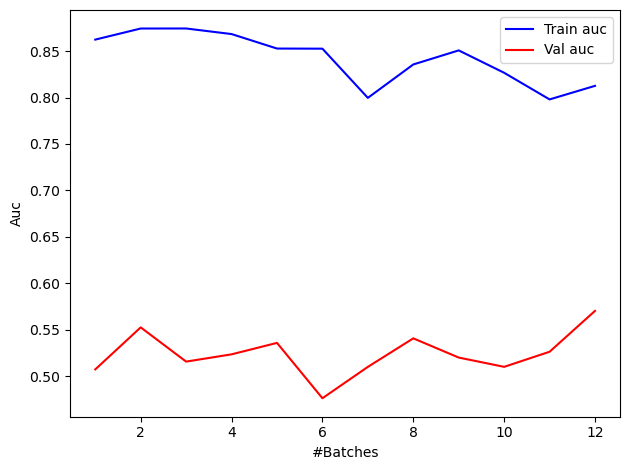

In [ ]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

In [ ]:
X_test = test_preprocess_new['Content']
X_test = hashvec.transform(X_test)
value = clf.predict_proba(X_test)[:,1]
value

array([0.59867913, 0.71039762, 0.20938858, ..., 0.52613739, 0.40480274,
       0.42310348])

In [ ]:
file = pd.concat([test[['Id']], pd.DataFrame(value, columns=['Popularity'])], axis=1)
file

file.to_csv('data/submission.csv', index=False)